# Lab 03

The project is a continuation of what we started on the second lab. You will train a logistic regression classifier on manually extracted features.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
from torch import nn

## Loading the dataset

We load the dataset from the previous notebook.

In [2]:
from datasets import Dataset
from datasets import load_dataset
from datasets import load_dataset_builder

dataset = load_dataset_builder("imdb")
dataset_train = load_dataset("imdb", split='train')
dataset_test = load_dataset("imdb", split='test')
dataset_unsupervised = load_dataset("imdb", split='unsupervised')

Found cached dataset imdb (/home/timothee/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Found cached dataset imdb (/home/timothee/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)
Found cached dataset imdb (/home/timothee/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


In [3]:
punctuation_filter = ['"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
                      ',', '.', '/', ':', ';', '<', '=', '>', '?', '@',
                      '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~']

def to_lower_case(row: dict) -> dict:
    """
    Lower text field in the row dict
    return: updated row
    """
    row['text'] = row['text'].lower()
    return row

def remove_punctuation(row: dict) -> dict:
    """
    Replace punctuation from punctuation_filter list to
    spaces in the text field of row dict
    return: updated row
    """
    for punctuation in punctuation_filter:
        row['text'] = row['text'].replace(punctuation, ' ')
    row['text'] = row['text'].replace('!', ' ! ')
    return row

def preprocessing(row: dict) -> dict:
    """
    Lower text field in the row dict and replace punctuation
    from punctuation_filter list to spaces in the text field
    of row dict
    return: updated row
    """
    return to_lower_case(remove_punctuation(row))

In [4]:
preprocess_train = dataset_test.map(preprocessing)
preprocess_test = dataset_train.map(preprocessing)
preprocess_unsupervised = dataset_unsupervised.map(preprocessing)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Features (6 points)

In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import math

## Get positive and negative lexicons

In [10]:
data = pd.read_csv('vader_lexicon.txt', delimiter='	', names=['token', 'sentiment', 'A', 'B'])
data = data.drop(columns=['A', 'B'])
positive = data.loc[data.sentiment >= 1]
positive = positive["token"].values.tolist()
negative = data.loc[data.sentiment <= -1]
negative = negative["token"].values.tolist()

## Vectorize text
For every given text, we want to generate a vector with the features seen in class.

(6 points) Code the following features:

- 1 if "no" appears in the document, 0 otherwise.
- The count of first and second pronouns in the document.
- 1 if "!" is in the document, 0 otherwise.
- Log(word count in the document).
- Number of words in the document which are in the positive lexicon.
- Number of words in the document which are in the negative lexicon.

In [11]:
pronouns = ['I', 'you', 'we'] 
def Vectorizer(documents: list[str]):
    """
    Vectorize the documents
    return list of vectors
    """
    X = []
    for doc in documents:
        words = doc.split()

        positive_count = 0
        negative_count = 0
        pronoun_count = 0
        for word in words:
            if word in pronouns:
                pronoun_count += 1
            if word in positive:
                positive_count += 1
            elif word in negative:
                negative_count += 1

        vec = []
        # 1 if "no" appears in the document, 0 otherwise.
        if "no" in words:
            vec.append(1)
        else:
            vec.append(0)
            
        # The count of first and second pronouns in the document.
        vec.append(pronoun_count)
        
        # 1 if "!" is in the document, 0 otherwise.
        if "!" in doc:
            vec.append(1)
        else:
            vec.append(0)
        # Log(word count in the document).
        vec.append(math.log10(len(words)))
    
        # positive and negative lexicon
    
        vec.append(positive_count)
        vec.append(negative_count)

        X.append(vec)
    return X

In [12]:
%%time
dataset = Vectorizer(preprocess_train['text'])
dataset[:10]

CPU times: user 7min 46s, sys: 75 ms, total: 7min 46s
Wall time: 7min 47s


[[0, 1, 1, 2.380211241711606, 9, 8],
 [0, 5, 0, 2.3483048630481607, 16, 14],
 [0, 0, 0, 2.1367205671564067, 2, 3],
 [1, 0, 0, 2.5634810853944106, 9, 18],
 [0, 2, 1, 2.1367205671564067, 12, 2],
 [1, 0, 0, 2.2833012287035497, 8, 11],
 [1, 4, 0, 2.4771212547196626, 21, 11],
 [0, 2, 0, 2.2380461031287955, 6, 15],
 [0, 3, 1, 2.103803720955957, 6, 6],
 [0, 4, 0, 2.2528530309798933, 7, 14]]

In [13]:
all_points = torch.tensor(dataset, dtype=torch.float32)
# norm result btw -1 and 1
#pre_labels = np.array(preprocess_train['label']) * 2 - 1
pre_labels = np.array(preprocess_train['label'])
labels = torch.tensor(pre_labels, dtype=torch.float32).reshape(-1, 1)
print('Train dataset:', all_points.shape)

X_train, X_test, y_train, y_test = train_test_split(
    all_points,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42,
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42,
)

print('X_train len:', X_train.shape)
print('X_test len:', X_test.shape)
print('X_valid len:', X_valid.shape)


Train dataset: torch.Size([25000, 6])
X_train len: torch.Size([16000, 6])
X_test len: torch.Size([5000, 6])
X_valid len: torch.Size([4000, 6])


# Logistic regression classifier (6 points)

In [14]:
class LinearRegression(nn.Module):
    """A linear regression implementation"""

    def __init__(self, input_dim: int, nb_classes: int) -> None:
        """
        Args:
            input_dim: the dimension of the input features.
            nb_classes: the number of classes to predict.
        """
        super().__init__()
        self.linear = nn.Linear(input_dim, nb_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: the input tensor.
        Returns:
            The output of the linear layer.
        """
        return self.linear(x)

# Training the model

Adapt the code by adding your feature extractor and train a classifier.

In [15]:
model = LinearRegression(6, 1)
# Stochastic gradient descent
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.5)

In [ ]:
%%time

n_epochs = 10000

# Keeping an eye on the losses
train_losses = []
test_losses = []

# Training loop
for epoch in range(n_epochs):
    # Setting all gradients to zero.
    optimizer.zero_grad()

    # Sending the whole training set through the model.
    predictions = model(X_train)
    # Computing the loss.
    loss = criterion(predictions, y_train)
    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(loss)
    # Computing the gradients and gradient descent.
    loss.backward()
    optimizer.step()

    # When computing the validation loss, we do not want to update the weights.
    # torch.no_grad tells PyTorch to not save the necessary data used for
    # gradient descent.
    with torch.no_grad():
        predictions = model(X_valid)
        loss = criterion(predictions, y_valid)
        test_losses.append(loss)

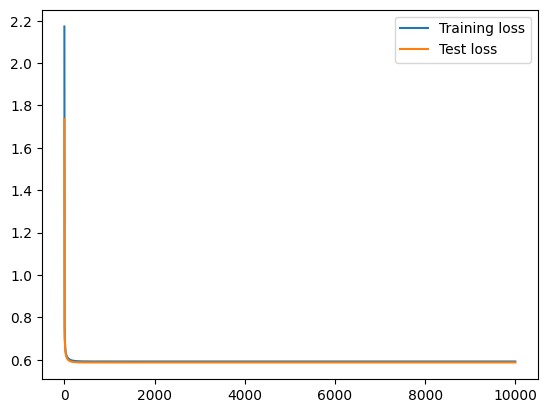

In [17]:
# Checking the losses
plt.plot(np.arange(len(train_losses)), train_losses, label="Training loss")
plt.plot(np.arange(len(test_losses)), test_losses, label="Test loss")
plt.legend()

(1 point) Evaluate your classifier in terms of accuracy for the training, validation, and test set.

In [21]:
# Note that we need to use a sigmoid on the output now.
with torch.no_grad():
    p_train = torch.sigmoid(model(X_train))
    p_train = np.round(p_train.numpy())
    training_accuracy = np.mean(p_train == y_train.numpy())
    p_valid = torch.sigmoid(model(X_valid))
    p_valid = np.round(p_valid.numpy())
    valid_accuracy = np.mean(p_valid == y_valid.numpy())
    p_test = torch.sigmoid(model(X_test))
    p_test = np.round(p_test.numpy())
    test_accuracy = np.mean(p_test == y_test.numpy())
print("Model accuracy:")
print(" - training:", training_accuracy)
print(" - valid:", valid_accuracy)
print(" - test:", test_accuracy)

Model accuracy:
 - training: 0.7124375 %
 - valid: 0.7145 %
 - test: 0.7148 %


In [22]:
# Predicting new samples
sample = 'This film was a very good one! I really like it.'
pre_sample = preprocessing({'text': sample})
print(pre_sample)
vec_sample = Vectorizer([pre_sample['text']])
print(vec_sample)
torch.sigmoid(model(torch.tensor(vec_sample, dtype=torch.float32)))

{'text': 'this film was a very good one !  i really like it '}
[[0, 0, 1, 1.0791812460476249, 2, 0]]


tensor([[0.5423]], grad_fn=<SigmoidBackward0>)

In [23]:
for name, param in model.named_parameters():
    print(name, param.data)

linear.weight tensor([[-0.0301, -0.0141, -0.0092, -0.0332,  0.1150, -0.1520]])
linear.bias tensor([-0.0154])


#### (1 point) Look at the weights of your classifier. Which features seems to play most for both classes?

The two last features of the vector are the one that matters the most. The positive word count feature have the biggest impact for the positive class and negative one for the negative class.

#### (1 point) Using one of the implementation, take at least 2 wrongly classified example from the test set and try explaining why the model failed.

In [55]:
for i in range(3000, len(preprocess_test['text'])):
    first_exemple = preprocess_test['text'][i]
    #print(preprocess_test['label'][i])
    #print("First Comment: '", first_exemple, "'")
    vec_sample = Vectorizer([first_exemple])
    p = torch.sigmoid(model(torch.tensor(vec_sample, dtype=torch.float32)))
    p = p[0][0].item()
    if round(p) != preprocess_test['label'][i]:
        if p < 0.35 or p > 0.9:
            print(i)
            break

3030


In [51]:
def check_text(text_id):
    """
    text_id: int
    Run model on the text id and print results
    """
    text = preprocess_test['text'][text_id]
    label = preprocess_test['label'][text_id]
    print("Text: '", text, "'")
    vec_sample = Vectorizer([text])
    p = torch.sigmoid(model(torch.tensor(vec_sample, dtype=torch.float32)))
    p = p[0][0].item()
    print("Vector: ", vec_sample)
    print("Text label: ", label, 'Positive' if label == 1 else 'Negative')
    print("Predict: ", p, 'Positive' if round(p) == 1 else 'Negative')

In [52]:
check_text(69)

Text: ' when an attempt is made to assassinate the emir of ohtar  an arab potentate visiting washington  d c   his life is saved by a cocktail waitress named sunny davis  sunny becomes a national heroine and media celebrity and as a reward is offered a job working for the protocol section of the united states department of state  unknown to her however  the state department officials who offer her the job have a hidden agenda  br    br   a map we see shows ohtar lying on the borders of saudi arabia and south yemen  in an area of barren desert known as the rub al-khali  or empty quarter  in real life a state in this location would have a population of virtually zero  and virtually zero strategic value  but for the purposes of the film we have to accept that ohtar is of immense strategic importance in the cold war and that the american government  who are keen to build a military base there  need to do all that they can in order to keep on the good side of its ruler  it transpires that t

We can see that this comment is wrongly preticted as positive by the algorhitm because the author tell us that while the actress is really pretty, it isn't enough to make the movie good. He praises a lot the actress, hence the confusion.

In [56]:
check_text(3030)

Text: ' when i finally had the opportunity to watch zombie 3 zombie flesheaters 2 in europe on an import region 2 japanese dvd i was blown away by just how entertaining this zombie epic is the transfer is just about immaculate as good as it s ever going to look unless anchor bay gets a hold of it the gore truly stands out like it should and you can really appreciate the excellent makeup and gore fx the sound is also terrific it s only 2 channel dolby but if you have a receiver with dolby prologic 2 you can really appreciate the cheesy music actually a very good score  and the effective although cheap sound effects it never sounded so good and the excellent transfer adds to the overall enjoyment  br    br   i never realized just how much blood flows in this film it s extremely brutal with exploding head shots exploding puss filled mega pimples a cleaver to a zombies throat a woman s burned off extremities how come it did nt burn the guy also  intestinal munching zombie babies and so muc

In this comment we cans see that the author is prasing the movie for being so bad it's good. The algorithm doesn't detect sarcasm. We can see that the vector of this 2 wrong examples have more words in the positive lexicon than negative.